# 位置编码
## 标准位置编码
位置编码描述序列中实体的位置或位置，以便为每个位置分配唯一的表示。 不使用单个数字（例如索引值）来表示Transformer模型中项目的位置有很多原因。 对于长序列，索引的大小可能会变大。 如果将索引值标准化为 0 到 1 之间，则可能会给可变长度序列带来问题，因为它们的标准化方式会有所不同。

Transformer 使用智能位置编码方案，其中每个位置/索引都映射到一个向量。 因此，位置编码层的输出是一个矩阵，其中矩阵的每一行表示序列的编码对象与其位置信息的总和。



<img src="../images/01.png" width="500" height="400" alt="position encoding" align=center />

假设有一个长度为L的输入序列，并要求位置 $k^{th}$ 为该序列中的对象。 位置编码由不同频率的正弦和余弦函数给出：

$P(k, 2i) = sin(\frac{k}{n^{\frac{2i}{d}}})$

$P(k, 2i + 1) = cos(\frac{k}{n^{\frac{2i}{d}}})$

参数含义: 
k: 输入序列中对象的位置, 0 <= k < L-1  
d: 输出嵌入空间的维度  
P(k, j): 位置函数，用于将输入序列中的位置 $k$ 映射到位置矩阵的索引 $(k,j)$  
n: 用户定义的标量，由《Attention Is All You Need》的作者设置为 10,000  
i: 用于映射到列索引 $0 \le k < \frac{d_{model}}{2} - 1$    

在上面的表达式中，可以看到偶数位置对应于正弦函数，奇数位置对应于余弦函数。

## 举例
当我们要编码「我 爱 你」的位置向量，假定每个token都具备512维，如果位置下标从0开始时，则根据位置编码的计算公式可得
当对pos = 0上的单词「我」进行位置编码时，它本身的维度有512维                 
$PE_0 = [sin(\frac{0}{10000^{\frac{0}{512}}}),cos(\frac{0}{10000^{\frac{0}{512}}}), sin(\frac{0}{10000^{\frac{2}{512}}}),cos(\frac{0}{10000^{\frac{2}{512}}}), sin(\frac{0}{10000^{\frac{4}{512}}}), cos(\frac{0}{10000^{\frac{4}{512}}}),..., sin(\frac{0}{10000^{\frac{510}{512}}}),cos(\frac{0}{10000^{\frac{510}{512}}})]$

当对pos = 1上的单词「爱」进行位置编码时，它本身的维度有512维

$PE_1 = [sin(\frac{1}{10000^{\frac{0}{512}}}),cos(\frac{1}{10000^{\frac{0}{512}}}), sin(\frac{1}{10000^{\frac{2}{512}}}),cos(\frac{1}{10000^{\frac{2}{512}}}), sin(\frac{1}{10000^{\frac{4}{512}}}), cos(\frac{1}{10000^{\frac{4}{512}}}),..., sin(\frac{1}{10000^{\frac{510}{512}}}),cos(\frac{1}{10000^{\frac{510}{512}}})]$
 然后再叠加上embedding向量，可得
 <img src="https://img-blog.csdnimg.cn/842bc985be9a453689a4aa7c534b1358.png">


当对pos = 2上的单词「你」进行位置编码时，它本身的维度有512维

$PE_2 = [sin(\frac{2}{10000^{\frac{0}{512}}}),cos(\frac{2}{10000^{\frac{0}{512}}}), sin(\frac{2}{10000^{\frac{2}{512}}}),cos(\frac{2}{10000^{\frac{2}{512}}}), sin(\frac{2}{10000^{\frac{4}{512}}}), cos(\frac{2}{10000^{\frac{4}{512}}}),..., sin(\frac{2}{10000^{\frac{510}{512}}}),cos(\frac{2}{10000^{\frac{510}{512}}})]$   
....

## 优势
**① 连续性和独特性：**   
这种编码方式为每个位置生成独一无二但又相互关联的编码。通过使用正弦和余弦波，相邻位置的编码是相似的，但每个位置的编码都是独特的。

**② 可扩展性：**  
由于使用的是三角函数，它允许模型推断超出训练数据长度的位置关系。换句话说，尽管模型在训练时可能只看到一定长度的序列，但它仍然能够处理更长的序列。

**③频率混合：**  
使用不同频率的正弦和余弦波可以让模型更容易学习位置之间的关系。较低频率的波允许模型捕捉更长范围的依赖性，而高频波则对应于更短距离的依赖性。

## 代码实现


### 基于 Numpy 实现


In [5]:
# 1. 从头开始编码位置编码矩阵

import numpy as np
import matplotlib.pyplot as plt

def getPosEncoding(seq_len, d, n=10000):
    '''
    seq_len : 序列长度
    d : 向量维度
    n : 一个超参数，用于确保不同位置的编码变化在一个合理的范围内,选择10000作为基数是为了在位置编码时能够覆盖更宽的频率范围。
    '''
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d) # 分母
            P[k, 2*i] = np.sin(k / denominator) # sin()，偶数
            P[k, 2*i+1] = np.cos(k / denominator) # cos()，奇数
    return P



In [8]:
x = getPosEncoding(seq_len=4, d=4, n=100)
x.shape

(4, 4)

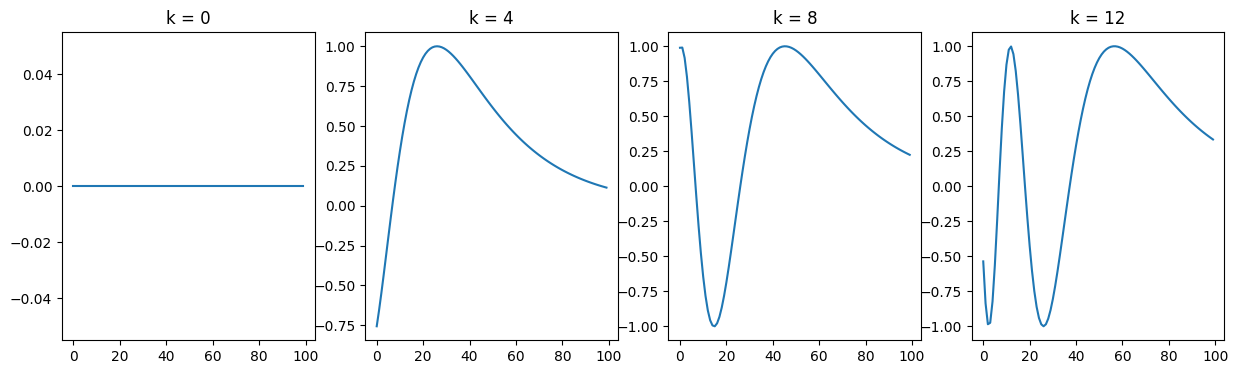

In [9]:
# 2. 了解位置编码矩阵

# 2.1 正弦波
# 为了理解位置编码，首先查看 n=10,000 和 d=512 的不同位置的正弦波。

def plotSine(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d) # 数组的每个元素都是 n 的 2*x/d 次方
    y = np.sin(k / denominator) # 输出
    plt.plot(x, y)
    plt.title('k = ' + str(k))
    
fig = plt.figure(figsize=(15,4))
for i in range(4):
    plt.subplot(141 + i) # 141 + i 表示的是子图的位置
    plotSine(k=i*4)

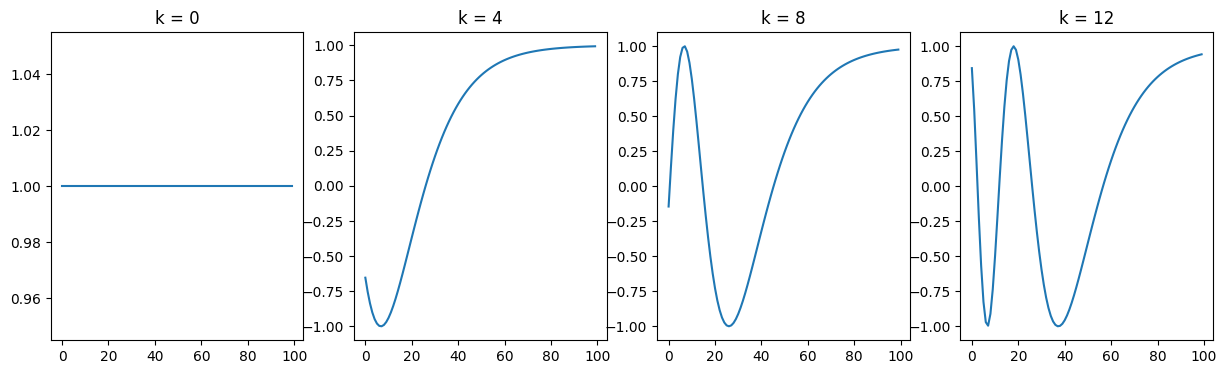

In [11]:
# 2.2 余弦波
# n=10,000 和 d=512 的不同位置的余弦波

def plotCosine(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d) # 数组的每个元素都是 n 的 2*x/d 次方
    y = np.cos(k / denominator) # 输出
    plt.plot(x, y)
    plt.title('k = ' + str(k))
    
fig = plt.figure(figsize=(15,4))
for i in range(4):
    plt.subplot(141 + i) # 141 + i 表示的是子图的位置
    plotCosine(k=i*4)

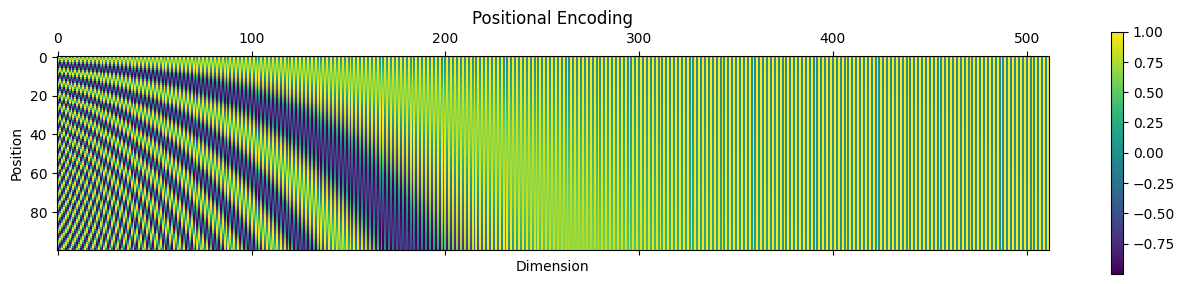

In [12]:
# 3. 可视化位置矩阵

# 使用matplotlib库中的matshow()方法，按照原始论文中的方法设置n=10,000，将得到以下结果：

P = getPosEncoding(seq_len=100, d=512, n=10000)

# 将位置编码矩阵P显示为一个热图
cax = plt.matshow(P) 

# plt.gcf()获取当前的图形，然后添加一个颜色条，这个颜色条对应于前面的matshow生成的热图。
plt.title("Positional Encoding")
plt.ylabel("Position")
plt.xlabel("Dimension")
plt.gcf().colorbar(cax)

## 基于 PyTorch 实现

<img src="../images/05.png">

因为 $a^x=e^{(x\cdot ln(a))}$，从而有$10000^{-\frac{i}{d_{model}}}=e^{(-\frac{i}{d_{model}}\cdot log(10000))}$

<img src="../images/04.png">

其中的中括号对应的是一个从 0 到 $d_{model}-1$ 的等差数列(步长为 2)，设为$i$

In [28]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model=512, max_len=100, n=10000):
        super(PositionalEncoding, self).__init__()
        # 创建一个位置编码矩阵
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1) # 扩充一维，用于后续广播操作
        
        # div_term是一个按指数缩放的序列，其目的是在计算正弦和余弦位置编码时提供不同的波长。
        # div_term可以确保每个维度上的编码频率是不同的，这种差异化的频率有助于模型在处理序列数据时捕捉到位置信息，
        # 因为每个位置的编码都是独一无二的，即使是对于长序列。
        # 计算了10000的自然对数，然后取其负值并除以d_model。这是为了生成一个缩放因子，用于调整位置编码的频率。
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(n) / d_model))
        
        # 偶数位置使用正弦函数
        pe[:, 0::2] = torch.sin(position * div_term)
        # 奇数位置使用余弦函数
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # 添加形状为（1， max_len， d_model） 的批次维度
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        # 注册为模型的持久状态，意味着它是模块的一部分。
        # 缓冲区是模块的一个持久状态，但它不是模型参数，也就是说，在模型训练过程中，它不会被认为是需要梯度更新的参数。
        self.register_buffer("pe", pe)
        
    def forward(self, x):
        # 将位置编码添加到输入序列的每一个元素上
        x = x + self.pe[:x.size(0), :]
        return x
    
        
        

In [29]:
# 测试

d_model = 512
seq_len = 100
n = 10000
batch_size = 1

pd_module = PositionalEncoding(d_model=d_model, max_len=seq_len, n=n)

# 假设输入数据 x
x = torch.zeros(seq_len, batch_size, d_model)

print(x.shape)

torch.Size([100, 1, 512])


In [31]:
encoded_x = pd_module(x)

print(encoded_x.shape)

torch.Size([100, 1, 512])


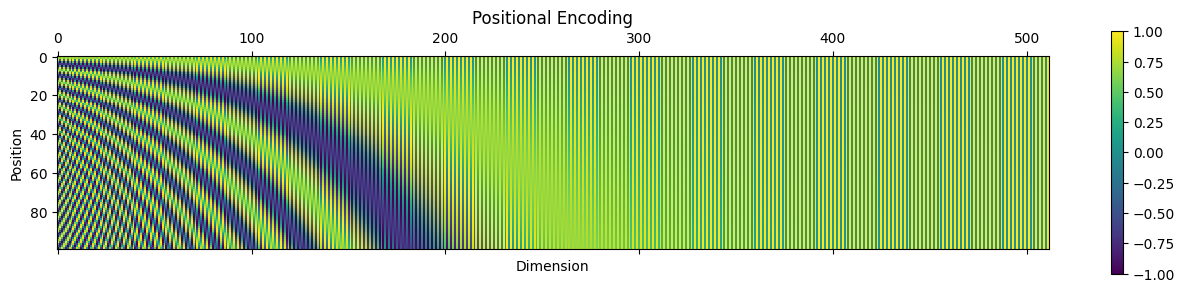

In [32]:
import matplotlib.pyplot as plt

# 调整数据形状以适应matshow函数
# 因为matshow需要2D数据，可以使用[seq_len, d_model]的形状
encoded_x = encoded_x.squeeze(1) # 移除batch维度

plt.matshow(encoded_x.numpy())
plt.colorbar()
plt.title("Positional Encoding")
plt.ylabel("Position")
plt.xlabel("Dimension")
plt.show()

## 旋转位置编码RoPE
所谓旋转位置编码，其在位置编码上删除了绝对位置嵌入，而在网络的每一层增加了苏剑林等人(2021)提出的旋转位置嵌入(RoPE)，其思想是采用绝对位置编码的形式 实现相对位置编码，且RoPE主要借助了复数的思想

具体来说，当咱们给self-attention中的q,k,v向量都加入了位置信息后，便可以表示为
$$\begin{aligned} \boldsymbol{q}_{m} & =f_{q}\left(\boldsymbol{x}_{m}, m\right) \\ \boldsymbol{k}_{n} & =f_{k}\left(\boldsymbol{x}_{n}, n\right) \\ \boldsymbol{v}_{n} & =f_{v}\left(\boldsymbol{x}_{n}, n\right) \end{aligned}$$

其中
- $q_m$表示「第 m个 token 对应的词向量 $x_m$」集成「位置信息 $m$」之后的 query 向量
- $k_n$、 $v_n$分别表示第 n个 token 对应的词向量 $x_n$集成位置信息 n之后的 key 向量、value 向量


### 推导方式一
接着论文中提出为了能利用上 token 之间的相对位置信息，假定 query 向量$q_m$和$key$向量$k_n$之间的内积操作可以被一个函数$g$表示，该函数$g$的输入是词嵌入向量$x_m$、$x_n$，和它们之间的相对位置 $m−n$：
$$<f_{q}\left(x_{m}, m\right), f_{k}\left(x_{n}, n\right)>=g\left(x_{m}, x_{n}, m-n\right)$$

> 这里面其实有很大的一个关键，但大部分资料甚至RoPE原始论文都不会给你特别强调出来，即为何要构造这么一个等式呢？
>
>原因在于左边算是q和k向量的内积，而这恰好是transformer计算自注意力机制的核心一步，右边等式则意味着m与n的相对位置
如此一来，该等式便把“q和k的内积”与“它们的相对位置”给串起来了
也如阿荀所说，左边是含有各自绝对位置信息的q向量和k向量，而这个等式就是RoPE追求的目标，物理含义就是通过显式传入绝对位置信息实现与传入相对位置信息对等的情况


假定现在词嵌入向量的维度是两维 d=2，然后RoPE利用2维度平面上的向量的几何性质，再结合复数的性质，神奇般的找到了满足上述等式的 f和 g，其形式如下：

$$x_m^{\prime}=f_{q}\left(\boldsymbol{x}_{m}, m\right)=W_q x_m e^{i m \theta}=\left(W_q x_m\right) e^{i m \theta}=q_m e^{i m \theta}$$
$$x_n^{\prime}=f_{k}\left(\boldsymbol{x}_{n}, n\right)=W_k x_n e^{i n \theta}=\left(W_k x_n\right) e^{i n \theta}=k_n e^{i n \theta}$$
$$x^T x_n^{\prime}=g\left(\boldsymbol{x}_{m}, \boldsymbol{x}_{n}, m-n\right)=\left(q_m^1 q_m^2\right)\left(\begin{array}{cc}
\cos ((m-n) \theta) & -\sin ((m-n) \theta) \\
\sin ((m-n) \theta) & \cos ((m-n) \theta)
\end{array}\right)\binom{k_n^1}{k_n^2}$$



**推导证明(d=2)**
$$x_m^{\prime}=W_q x_m e^{i m \theta}=\left(W_q x_m\right) e^{i m \theta}=q_m e^{i m \theta} q_m=\left(\begin{array}{cc}
W_q^{11} & W_q^{12} \\
W_q^{21} & W_q^{22}
\end{array}\right)\binom{x_m^1}{x_m^2}=\binom{q_m^1}{q_m^2}$$

二维向量可以表示成虚数形式应为问量的一个维度表示一个坐标,类比到实数坐标和虚数坐标        
$q_m=q_m^1+\mathrm{i} q_m^2$   （1）

根据欧拉公式： $e^{\mathrm{i} m \theta}=\cos (m \theta)+\mathrm{i} \sin (m \theta)$ （2）

根据（1）和（2）带入得到：   
$q_m e^{\mathrm{i} m \theta}=\left(q_m^1+\mathrm{i} q_m^2\right)(\cos (m \theta)+\mathrm{i} \sin (m \theta))$     
$=\left(q_m^1 \cos (m \theta)-q_m^2 \sin (m \theta)\right)+\mathrm{i}\left(q_m^2 \cos (m \theta)+q_m^1 \sin (m \theta)\right)$

$=\left[q_m^1 \cos (m \theta)-q_m^2 \sin (m \theta), q_m^2 \cos (m \theta)+q_m^1 \sin (m \theta)\right]=\left(\begin{array}{cc}
\cos (m \theta) & -\sin (m \theta) \\
\sin (m \theta) & \cos (m \theta)
\end{array}\right)\binom{q_m^1}{q_m^2}$








**因此**，我们类比得到$x'_m,x'_n$的结果：
$$x_m^{\prime}=W_q x_m e^{i m \theta}=\left(W_q x_m\right) e^{i m \theta}=q_m e^{i m \theta} \quad=\left(\begin{array}{cc}
\cos (m \theta) & -\sin (m \theta) \\
\sin (m \theta) & \cos (m \theta)
\end{array}\right)\binom{q_m^1}{q_m^2}$$

$$x_n^{\prime}=W_k x_n e^{i n \theta} \quad=\left(W_k x_n\right) e^{i n \theta}=q_k e^{i n \theta} \quad=\left(\begin{array}{cc}
\cos (n \theta) & -\sin (n \theta) \\
\sin (n \theta) & \cos (n \theta)
\end{array}\right)\binom{k_n^1}{k_n^2}$$

带入到内积中：
$$x_m^T x_n^{\prime}=\left(\left(\begin{array}{cc}
\cos (m \theta) & -\sin (m \theta) \\
\sin (m \theta) & \cos (m \theta)
\end{array}\right)\binom{q_m^1}{q_m^2}\right)^T\left(\begin{array}{cc}
\cos (n \theta) & -\sin (n \theta) \\
\sin (n \theta) & \cos (n \theta)
\end{array}\right)\binom{k_n^1}{k_n^2}$$

$$=\left(\begin{array}{ll}
q_m^1 & q_m^2
\end{array}\right)\left(\begin{array}{cc}
\cos (m \theta) & \sin (m \theta) \\
-\sin (m \theta) & \cos (m \theta)
\end{array}\right)\left(\begin{array}{cc}
\cos (n \theta) & -\sin (n \theta) \\
\sin (n \theta) & \cos (n \theta)
\end{array}\right)\binom{k_n^1}{k_n^2}$$

$$=\left(\begin{array}{ll}
q_m^1 & q_m^2
\end{array}\right)\left(\begin{array}{cc}
\cos (m \theta) \cos (n \theta)+\sin (m \theta) \sin (n \theta) & -\cos (m \theta) \sin (n \theta)+\sin (m \theta) \cos (n \theta) \\
-\sin (m \theta) \cos (n \theta)+\cos (m \theta) \sin (n \theta) & \sin (m \theta) \sin (n \theta)+\cos (m \theta) \cos (n \theta)
\end{array}\right)\binom{k_n^1}{k_n^2}$$

根据三角函数公式：
$$\begin{aligned}
& \sin (m \theta+n \theta)=\sin (m \theta) \cos (n \theta)+\cos (m \theta) \sin (n \theta) \\
& \sin (m \theta-n \theta)=\sin (m \theta) \cos (n \theta)-\cos (m \theta) \sin (n \theta) \\
& \cos (m \theta+n \theta)=\cos (m \theta) \cos (n \theta)-\sin (m \theta) \sin (n \theta) \\
& \cos (m \theta-n \theta)=\cos (m \theta) \cos (n \theta)+\sin (m \theta) \sin (n \theta)
\end{aligned}$$

根据三角函数带入可以得到：
$$=\left(\begin{array}{ll}
q_m^1 & q_m^2
\end{array}\right)\left(\begin{array}{cc}
\cos ((m-n) \theta) & -\sin ((m-n) \theta) \\
\sin ((m-n) \theta) & \cos ((m-n) \theta)
\end{array}\right)\binom{k_n^1}{k_n^2}$$

**多维度扩展**
$$x_m^{\prime}=\left(\begin{array}{cc}
\cos (m \theta) & -\sin (m \theta) \\
\sin (m \theta) & \cos (m \theta)
\end{array}\right)\binom{q_m^1}{q_m^2} \quad x_n^{\prime}=\left(\begin{array}{cc}
\cos (n \theta) & -\sin (n \theta) \\
\sin (n \theta) & \cos (n \theta)
\end{array}\right)\binom{q_n^1}{q_n^2}$$


多维度？
$$\left(\begin{array}{ccccccc}
\cos m \theta_0 & -\sin m \theta_0 & 0 & 0 & \cdots & 0 & 0 \\
\sin m \theta_0 & \cos m \theta_0 & 0 & 0 & \cdots & 0 & 0 \\
0 & 0 & \cos m \theta_1 & -\sin m \theta_1 & \cdots & 0 & 0 \\
0 & 0 & \sin m \theta_1 & \cos m \theta_1 & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & \cos m \theta_{d / 2-1} & -\sin m \theta_{d / 2-1} \\
0 & 0 & 0 & 0 & \cdots & \sin m \theta_{d / 2-1} & \cos m \theta_{d / 2-1}
\end{array}\right)\left(\begin{array}{c}
q_0 \\
q_1 \\
q_2 \\
q_3 \\
\vdots \\
q_{d-2} \\
q_{d-1}
\end{array}\right)$$


每两个维度一组，进行旋转操作。

每组应用同样的旋转操作且每组的旋转角度计算方式如下：   
$\theta_i=10000^{-2 i / d}, i \in\left[1,2, \ldots, \frac{d}{2}\right]$


可以看到矩阵中有很多元素是 0,如果用矩阵乘法, 其实有很多计算是无用的

简化：

$$\left(\begin{array}{c}
q_0 \\
q_1 \\
q_2 \\
q_3 \\
\vdots \\
q_{d-2} \\
q_{d-1}
\end{array}\right) \otimes\left(\begin{array}{c}
\cos m \theta_0 \\
\cos m \theta_0 \\
\cos m \theta_1 \\
\cos m \theta_1 \\
\vdots \\
\cos m \theta_{d / 2-1} \\
\cos m \theta_{d / 2-1}
\end{array}\right)+\left(\begin{array}{c}
-q_1 \\
q_0 \\
-q_3 \\
q_2 \\
\vdots \\
-q_{d-1} \\
q_{d-2}
\end{array}\right) \otimes\left(\begin{array}{c}
\sin m \theta_0 \\
\sin m \theta_0 \\
\sin m \theta_1 \\
\sin m \theta_1 \\
\vdots \\
\sin m \theta_{d / 2-1} \\
\sin m \theta_{d / 2-1}
\end{array}\right)$$

其中⊗为矩阵逐位相乘操作

所以简单来说 RoPE 的 self-attention 操作的流程是
<img src="../images/06.png">


### 旋转位置编码的coding实现(分非LLaMA版和LLaMA版两种)
sinusoidal_position_embedding：这个函数用来生成正弦形状的位置编码。这种编码用来在序列中的令牌中添加关于相对或绝对位置的信息

In [33]:
def sinusoidal_position_embedding(batch_size, nums_head, max_len, output_dim, device):
    # (max_len, 1)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(-1)
 
    # (output_dim//2)
    # 即公式里的i, i的范围是 [0,d/2]
    ids = torch.arange(0, output_dim // 2, dtype=torch.float)  
    theta = torch.pow(10000, -2 * ids / output_dim)
 
    # (max_len, output_dim//2)
    # 即公式里的：pos / (10000^(2i/d))
    embeddings = position * theta 
 
    # (max_len, output_dim//2, 2)
    embeddings = torch.stack([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
 
    # (bs, head, max_len, output_dim//2, 2)
    # 在bs维度重复，其他维度都是1不重复
    embeddings = embeddings.repeat((batch_size, nums_head, *([1] * len(embeddings.shape))))  
 
    # (bs, head, max_len, output_dim)
    # reshape后就是：偶数sin, 奇数cos了
    embeddings = torch.reshape(embeddings, (batch_size, nums_head, max_len, output_dim))
    embeddings = embeddings.to(device)
    return embeddings

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
 
 
def RoPE(q, k):
    # q,k: (bs, head, max_len, output_dim)
    batch_size = q.shape[0]
    nums_head = q.shape[1]
    max_len = q.shape[2]
    output_dim = q.shape[-1]
 
    # (bs, head, max_len, output_dim)
    pos_emb = sinusoidal_position_embedding(batch_size, nums_head, max_len, output_dim, q.device)
 
 
    # cos_pos,sin_pos: (bs, head, max_len, output_dim)
    # 看rope公式可知，相邻cos，sin之间是相同的，所以复制一遍。如(1,2,3)变成(1,1,2,2,3,3)
    cos_pos = pos_emb[...,  1::2].repeat_interleave(2, dim=-1)  # 将奇数列信息抽取出来也就是cos 拿出来并复制
    sin_pos = pos_emb[..., ::2].repeat_interleave(2, dim=-1)  # 将偶数列信息抽取出来也就是sin 拿出来并复制
 
    # q,k: (bs, head, max_len, output_dim)
    q2 = torch.stack([-q[..., 1::2], q[..., ::2]], dim=-1)
    q2 = q2.reshape(q.shape)  # reshape后就是正负交替了
 
    # 更新qw, *对应位置相乘
    q = q * cos_pos + q2 * sin_pos
 
    k2 = torch.stack([-k[..., 1::2], k[..., ::2]], dim=-1)
    k2 = k2.reshape(k.shape)
    # 更新kw, *对应位置相乘
    k = k * cos_pos + k2 * sin_pos
 
    return q, k

def attention(q, k, v, mask=None, dropout=None, use_RoPE=True):
    # q.shape: (bs, head, seq_len, dk)
    # k.shape: (bs, head, seq_len, dk)
    # v.shape: (bs, head, seq_len, dk)
 
    if use_RoPE:
        # 使用RoPE进行位置编码
        q, k = RoPE(q, k)
 
    d_k = k.size()[-1]
 
    # 计算注意力权重
    # (bs, head, seq_len, seq_len)
    att_logits = torch.matmul(q, k.transpose(-2, -1))  
    att_logits /= math.sqrt(d_k)
 
    if mask is not None:
        # 对权重进行mask，将为0的部分设为负无穷大
        att_scores = att_logits.masked_fill(mask == 0, -1e-9)  
 
    # 对权重进行softmax归一化
    # (bs, head, seq_len, seq_len)
    att_scores = F.softmax(att_logits, dim=-1)  
 
    if dropout is not None:
        # 对权重进行dropout
        att_scores = dropout(att_scores)
 
    # 注意力权重与值的加权求和
    # (bs, head, seq_len, seq_len) * (bs, head, seq_len, dk) = (bs, head, seq_len, dk)
    return torch.matmul(att_scores, v), att_scores
 
 
if __name__ == '__main__':
    # (bs, head, seq_len, dk)
    q = torch.randn((8, 12, 10, 32))
    k = torch.randn((8, 12, 10, 32))
    v = torch.randn((8, 12, 10, 32))
 
    # 进行注意力计算
    res, att_scores = attention(q, k, v, mask=None, dropout=None, use_RoPE=True)
 
    # 输出结果的形状
    # (bs, head, seq_len, dk),  (bs, head, seq_len, seq_len)
    print(res.shape, att_scores.shape)

#### LLaMA版的实现

In [35]:
def precompute_freqs_cis(dim: int, end: int, theta: float = 1000.0):
    '''预先计算频率和复数的cosine和sine值，用于后续的Positional Encoding
    dim: 维度
    end: 一个序列的最大长度或位置的最大值
    theta: 用于计算频率的超参数，默认值为1000.0
    '''
    # ① 生成一个等比数列，即频率（frequencies），这种方法是基于 "Attention is All You Need" 论文中描述的位置编码。
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    
    # ② 生成了一个从0到end的序列
    t = torch.arange(end, device=freqs.device)
    
    # ③ 计算两个向量的外积
    # 外积的计算方式是将第一个向量的每个元素都乘以第二个向量，形成一个矩阵。
    # 结果矩阵的形状是（end, dim//2）
    freqs = torch.outer(t, freqs).float()
    
    # ④ 将极坐标转换为复数形式
    # torch.polar(r, theta): 是一个函数，它接受两个参数：模 r 和相位 theta，然后返回一个复数，
    #                       该复数的实部为 r * cos(theta)，虚部为 r * sin(theta)。
    # torch.ones_like(freqs): 生成一个与 freqs 形状相同的张量，但所有元素都是1，这意味着模r为1。
    # freqs: 它表示每个位置的相位或角度。
    # freqs_cis: 是一个形状为（end, dim//2）的复数矩阵，每个元素都是一个复数，用于后续的位置编码。
    
    ### 这行代码实际上为每个位置和每个频率生成了一个复数，其模为1，而相位为我们之前计算的频率。
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis


'''深入理解: 
问:  为什么要这样做？
答:  当我们在编码序列位置时，我们希望为每个位置生成一个唯一的编码，这样模型就可以区分它们。
     通过使用不同的频率和相位来生成这些编码，我们可以确保位置编码是唯一的并且可以随着序列位置的增加而变化。
     这种复数形式的编码方式可以为模型提供关于序列中不同位置之间关系的丰富信息，从而帮助模型更好地学习序列数据。
'''

'深入理解: \n问:  为什么要这样做？\n答:  当我们在编码序列位置时，我们希望为每个位置生成一个唯一的编码，这样模型就可以区分它们。\n     通过使用不同的频率和相位来生成这些编码，我们可以确保位置编码是唯一的并且可以随着序列位置的增加而变化。\n     这种复数形式的编码方式可以为模型提供关于序列中不同位置之间关系的丰富信息，从而帮助模型更好地学习序列数据。\n'

In [38]:
# 参数
dim = 10 # 维度
end = 100 # 序列长度
theta = 1000.0

# 获取位置编码的复数值
freqs_cis = precompute_freqs_cis(dim, end, theta)
freqs_cis.size()

torch.Size([100, 5])

In [39]:
freqs_cis[0]

tensor([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

real_values shape :  torch.Size([100, 5])
imag_values shape :  torch.Size([100, 5])


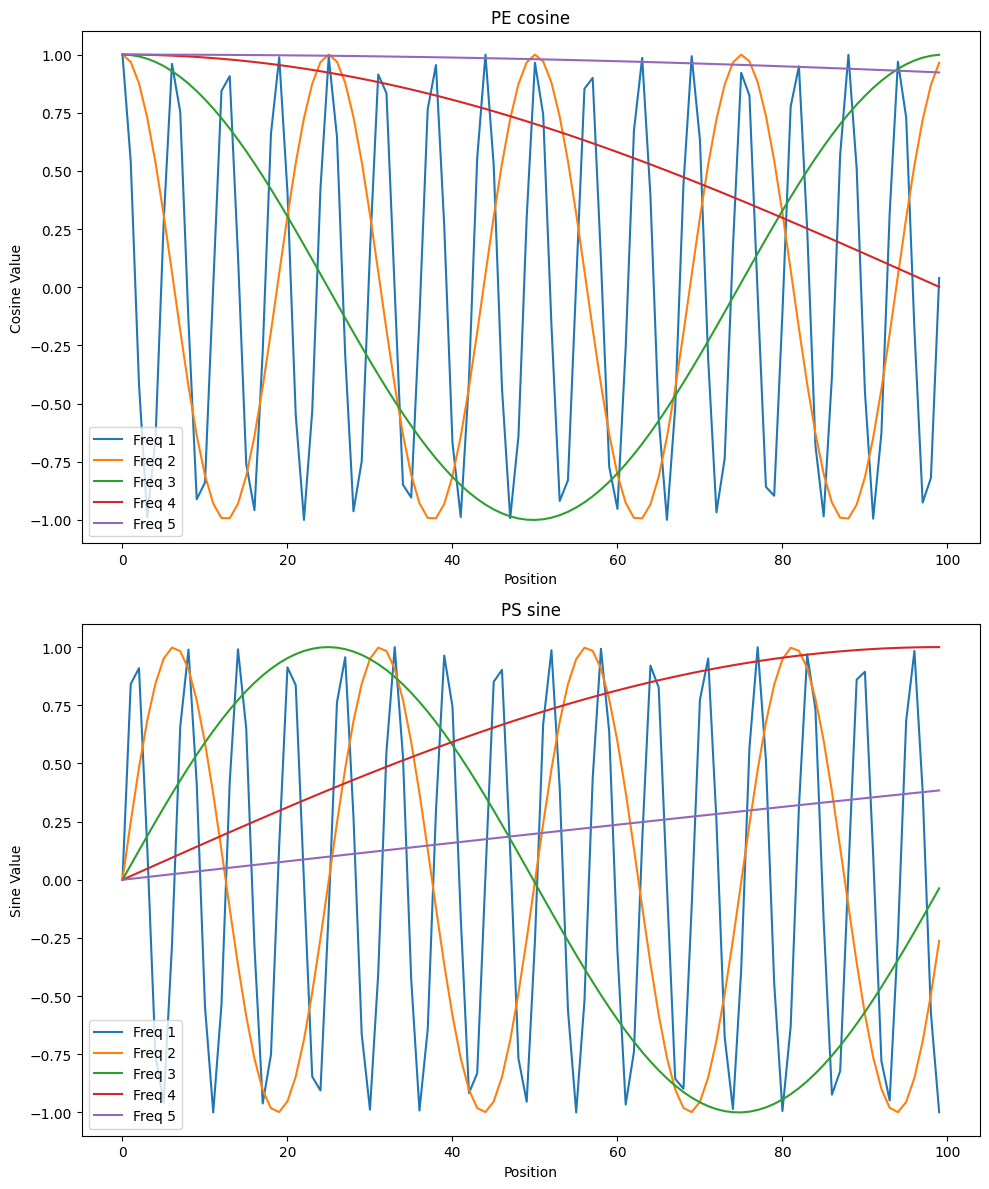

In [36]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action="ignore")

# 参数
dim = 10 # 维度
end = 100 # 序列长度
theta = 1000.0

# 获取位置编码的复数值
freqs_cis = precompute_freqs_cis(dim, end, theta)

# 获取实部(cosine值）和虚部(sine值）
real_values = freqs_cis.real
print("real_values shape : ", real_values.shape)
imag_values = freqs_cis.imag
print("imag_values shape : ", imag_values.shape)

# 绘制实部和虚部值
positions = torch.arange(end)
plt.figure(figsize=(10, 12))

# 图-1 ： 绘制cosine值（实部）
plt.subplot(2, 1, 1)
for i in range(real_values.size(1)):
    plt.plot(positions, real_values[:, i], label=f'Freq {i+1}')
plt.title("PE cosine")
plt.xlabel("Position")
plt.ylabel("Cosine Value")
plt.legend()

# 图-2 ：绘制sine值（虚部）
plt.subplot(2, 1, 2)
for i in range(imag_values.size(1)):
    plt.plot(positions, imag_values[:, i], label=f'Freq {i+1}')
plt.title("PS sine")
plt.xlabel("Position")
plt.ylabel("Sine Value")
plt.legend()

plt.tight_layout()
plt.show()

**1. 假设函数参数**   
   
期望的位置编码维度是4   
dim=4   

序列的最大长度或位置是3   
end=3   
  
**2. 生成等比数列**        
freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))  

首先看 torch.arange(0, dim, 2)，它返回一个从0开始，步长为2的序列，长度为dim，最终返回 [0, 2]。  
接下来, [0, 2] 除以 dim=4 得到 [0, 0.5]。之后这个值用来计算 theta 的幂，得到 [1, sqrt(theta)]。  

**3. 生成一个从0到end的序列**   
t = torch.arange(end, device=freqs.device)  

将生成一个从 0 到 end-1 的序列。在我们的例子中，这将返回 [0, 1, 2]。

**4. 计算两个向量的外积**  
freqs = torch.outer(t, freqs).float()

外积的计算方法是：第一个向量的每个元素都乘以第二个向量，得到一个矩阵。  
在这里，我们有 [0, 1, 2] 和 [1, 1/sqrt(theta)]。  
<font color=red>每一行代表一个位置，每一列代表一个频率。 </font>    
外积操作的结果是：
```shell
[[0, 0],
 [1, 1/sqrt(theta)],
 [2, 2/sqrt(theta)]]
```

**5. 将极坐标转换为复数形式**  
freqs_cis = torch.polar(torch.ones_like(freqs), freqs)

使用 torch.polar 将极坐标（由模和相位表示）转换为复数形式。这里，模为1（即所有的频率值都被乘以1），而相位则由先前计算的 freqs 提供。


**6. 返回值**  
return freqs_cis

返回了上面步骤生成的复数矩阵   


**7. 实际输出**  
运行precompute_freqs_cis(dim=4, end=3)：

输出：
```shell
tensor([[[ 1.0000 + 0.0000j],
         [ 1.0000 + 0.0000j]],
        
        [[ 1.0000 + 0.0000j],
         [ 0.5403 + 0.8415j]],
        
        [[ 1.0000 + 0.0000j],
         [-0.4161 + 0.9093j]]], dtype=torch.complex64)

```  

上述输出表示：

- 对于位置0，所有的频率产生了相同的复数，其模为1，相位为0。  
- 对于位置1，第一个频率仍然产生了相同的复数，但第二个频率产生了一个不同的复数，其模为1，相位为其对应的值。  
- 对于位置2，同样的规律适用，但相位值与位置1不同。  

这些复数值可以用于进一步的位置编码计算。


**8. 结论**  

① 位置与相位(角度)的关系:  
- 每个位置的复数相位与其对应的位置值乘以特定频率有关。
- 例如，对于位置1和第二个频率，相位不为0。而对于位置2，该频率的相位又有所不同。这意味着随着位置的增加，该频率的相位也会发生变化。

② 每个位置的第一个频率都是相同的:
- 对于第一个频率，每个位置的复数都是相同的（实部为1，虚部为0，这意味着相位为0）。这是因为这个特定的频率值是1，不受位置的影响。

③ 模始终为1:
- 无论位置或频率如何，每个复数的模都始终为1。这是因为我们使用torch.ones_like(freqs)作为torch.polar的第一个参数。

④ 位置编码的周期性与频率有关:
- 由于相位是基于位置和频率的乘积，不同的频率具有不同的周期性。在上述示例中，第二个频率具有比第一个频率更高的周期性，因为相位值随位置更快地变化。

⑤ 捕获细粒度和粗粒度的位置信息:
- 由于不同的频率具有不同的周期性，它们可以同时捕获细粒度和粗粒度的位置信息。低频率可以捕获长距离的位置关系，而高频率可以捕获相邻位置之间的细微差异。

⑥ 复数表示的重要性:
- 使用复数形式为每个位置编码提供了cosine和sine值，这两个值都是有用的并被用于后续的神经网络计算。这是因为cosine和sine值能够为每个位置提供独特且连续的编码，而不会随着位置的增加而重复。

In [54]:

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    '''根据NumPy和PyTorch的广播机制，当两个Tensor进行运算时，如果他们的shape不相同，
       那么他们会自动对齐最后一个维度，然后对其他维度进行扩展以满足相同的shape。
       
       这个函数的目的是为了确保freqs_cis可以根据广播规则与x进行元素级别的运算，特别是在x的维度数量大于2时。
       '''
    # 获取x的维度数量
    ndim = x.ndim
    
    # 确保x至少有两个维度
    assert ndim > 1
    
    # freqs_cis的形状与x的第二和最后一个维度相匹配
    print("----", (x.shape[1], x.shape[-1]))
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    
    # 遍历x的每个维度，并为第二和最后一个维度保留其原始大小，而为所有其他维度赋值1。
    # 这是为了确保广播时，除了这两个特定维度外，其他所有维度都能自动扩展。
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
   #  print(shape)
    # 使用view函数来重塑freqs_cis的形状以匹配新的形状
    return freqs_cis.view(*shape)

In [50]:
freqs_cis = torch.randn(3,4) # dim/2=4 dim=8
x = torch.randn(2, 3, 4)
print(freqs_cis.shape)
print(x.shape)

# 使用reshape_for_broadcast函数调整freqs_cis的形状
reshaped_freqs_cis = reshape_for_broadcast(freqs_cis, x)
print(reshaped_freqs_cis.shape)

# 求和
s = reshaped_freqs_cis + x
print(s.shape)

torch.Size([3, 4])
torch.Size([2, 3, 4])
torch.Size([1, 3, 4])
torch.Size([2, 3, 4])


#### 复数乘积的几何意义
我们先用复数的三角形式来计算一下，两个复数的乘积

$$\begin{aligned}
& z_1=r_1\left(\cos \left(\theta_1\right)+i \sin \left(\theta_1\right)\right) \\
& z_2=r_2\left(\cos \left(\theta_2\right)+i \sin \left(\theta_2\right)\right)
\end{aligned}$$


两个复数相乘

$$\begin{aligned}
& z_1 z_2=r_1 r_2\left(\cos \left(\theta_1\right)+i \sin \left(\theta_1\right)\right)\left(\cos \left(\theta_2\right)+i \sin \left(\theta_2\right)\right) \\
& =r_1 r_2\left[\cos \left(\theta_1\right) \cos \left(\theta_2\right)-\sin \left(\theta_1\right) \sin \left(\theta_2\right)+i\left(\sin \left(\theta_1\right) \cos \left(\theta_2\right)+\cos \left(\theta_1\right) \sin \left(\theta_2\right)\right)\right]
\end{aligned}$$

根据三角和差公式，可以得到

$$z_1 z_2=r_1 r_2\left[\cos \left(\theta_1+\theta_2\right)+i \sin \left(\theta_1+\theta_2\right)\right]$$

通过上面的公式，我们可以发现，复数相乘得到的新复数，模为两个复数模的乘积，$|z_1||z_2|$
，幅角为两个复数的幅角之和，$\arg \left(z_1 z_2\right)=\arg \left(z_1\right)+\arg \left(z_2\right)$，因此复数的乘积可以理解为拉伸与旋转


#### 几何解释

-  复数在复平面上  
首先，我们应该了解复数可以在“复平面”上被表示为点或向量。这是一个二维平面，其中水平轴表示复数的实部，而垂直轴表示复数的虚部。因此，复数`z = a + bi` 在复平面上的位置是点 `(a, b)` 。

-  几何解释  
在复平面上乘以两个复数时，可以分别乘以它们的模，并加上它们的角度。具体来说，如果 z1 和 z2 是两个复数，并且 r1 和 r2 是它们的模，而 $\theta_1$ 和 $\theta_2$ 是它们的角度，则它们的乘积 z1 x z2 的模为 r1 x r2，角度为 $\theta_1$ + $\theta_2$ , 
这意味着乘法在几何上有两个效果：  
**① 拉伸/压缩:** 将一个复数与另一个复数相乘会将第一个复数的长度乘以第二个复数的长度。  
**② 旋转:** 第一个复数将按照第二个复数的角度进行旋转。

In [51]:
from typing import Tuple
def apply_rotary_emb(
    xq: torch.Tensor, # 查询矩阵
    xk: torch.Tensor, # 键矩阵
    freqs_cis: torch.Tensor, # 旋转嵌入
) -> Tuple[torch.Tensor, torch.Tensor]:
    '''应用旋转嵌入（rotary embedding）的计算，旋转嵌入是一种特殊的位置嵌入方法，常用于Transformer系列模型，
       能帮助模型理解序列中的位置关系。将旋转嵌入应用到查询和键矩阵上，使得模型可以理解序列中的位置信息。
       旋转嵌入的优点是，它能在不增加计算复杂度的情况下增加模型的性能。'''
    
    # 首先将xq和xk张量转换为浮点数
    # 然后使用reshape将最后一个维度拆分为两个维度，每个维度都有大小为2，这样做是为了为复数张量提供实部和虚部。
    # 然后，torch.view_as_complex用于从实部和虚部创建复数张量
    
    # *xq.shape[:-1] 是保留原始形状的所有维度，除了最后一个维度。
    # -1 是一个占位符，它告诉PyTorch自动计算这个维度，以保持元素总数不变。
    # 2 是最后一个维度，这是为了为接下来的复数转换做准备。每个复数由两个浮点数表示（实部和虚部），所以最后一个维度是2。
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    
    # 将freqs_cis重新reshape以匹配xq_的形状，以便进行广播运算。
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    
    # 这两行代码将查询和键张量与旋转嵌入相乘，应用位置嵌入。
    # 函数计算xq_和xk_与freqs_cis的元素乘积（这是一个复数乘法），
    # 在复数乘法中，xq_和xk_的实部和虚部会分别与freqs_cis的实部和虚部进行乘法运算。
    # flatten(3) 将两个最后的维度合并回一个维度
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    
    # 函数返回经过旋转嵌入处理的查询和键张量，同时确保它们的数据类型与原始输入相匹配。
    return xq_out.type_as(xq), xk_out.type_as(xk)

In [55]:
# 1. 假设我们有以下的数据
# query矩阵
xq = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])  
# key矩阵
xk = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])  
print(xq.shape)
print(xk.shape)
# 频率张量
freqs_cis = torch.tensor([[1, 2], [3, 4]])  
print(freqs_cis.shape)

# 2. 现在要对query和key矩阵应用旋转嵌入
# 2.1 首先，apply_rotary_emb函数会将query和key矩阵reshape并转换为复数张量。
xq.float().reshape(*xq.shape[:-1], -1, 2).shape
xk.float().reshape(*xk.shape[:-1], -1, 2).shape

# 可以用torch.view_as_complex将这两个张量转换为复数张量
xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2)) 
xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
print(xq_.shape)
print(xk_.shape)
print(xq_)

# 3. 接下来，函数会将预先计算的频率张量调整为合适的形状以进行广播运算。
# 在我们的例子中，freqs_cis 的形状是 (2, 2)，所以我们需要将其形状调整为 (1, 2, 2, 1)。
freqs_cis_new = reshape_for_broadcast(freqs_cis, xq_)
print(freqs_cis_new.shape)

# 4. 接下来，函数会将复数张量与频率张量相乘。这是一个复数乘法，结果也是一个复数张量。

xq_out_complex = xq_ * freqs_cis_new
xk_out_complex = xk_ * freqs_cis_new


# 5. 然后，我们将结果重塑并转换回实数张量。
xq_out = torch.view_as_real(xq_out_complex).flatten(3)
xk_out = torch.view_as_real(xk_out_complex).flatten(3)
print(xq_out.shape)

torch.Size([2, 2, 2])
torch.Size([2, 2, 2])
torch.Size([2, 2])
torch.Size([2, 2, 1])
torch.Size([2, 2, 1])
tensor([[[1.+2.j],
         [3.+4.j]],

        [[5.+6.j],
         [7.+8.j]]])
-- (2, 1)


AssertionError: 